<img style="float:right" width="25%" src="EscudoColorTc.jpg">
<h1 style="display: inline-block; padding: 4mm; padding-left= 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px">

    Práctica 7: "Agentic workflow"
</h1>

## Gestión de la Información. Curso 2025-2026

## Alumnos:
* Belén Rodríguez Cánovas
* Fernando Arroyo Redondo
___

# Descripción del taller
## Implementación de un Workflow para Validación de IBAN con LangGraph, LangChain y OpenAI con un agente

Este agente puede ser útil para una empresa que quiere verificar la corrección de los datos bancarios de su personal y
de sus proveedores, con el fin de evitar retornos bancarios debido a errores, y con ello estar obligada al pago de intereses
de atraso o perder bonificaciones por pronto pago.

Este agente realiza las tareas siguientes:

1.- Lee un IBAN que se introduce por pantalla.

2.- Primero comprueba que el IBAN es correcto, con una comprobación simple de la estructura usando una análisis con el formato normalizado expresado en forma de una "expresión regular". Si la estructura es correcta pasa a comprobar  con openAI si, efectivamenete, el IBAN existe y es correcto. 

3.- Si es correcto, el agente devuelve la siguiente información por pantalla
* el propio IBAN,
* el nombre del Banco,
* el BIC del banco,
* la dirección del banco o agencia relacionado con ese IBAN.

4- tras esto acaba el workflow con éxito.

5- Si la estructura del IBAN no es correcta o éste no existe, lo indica por pantalla pidiendo una corrección del código para volver a empezar el proceso, por un máximo de tres veces.

6- Si después de los tres intentos no da un resultado correcto, indica por pantalla que se ha excedido el máximo de intentos y acaba el workflow con fallo, indicando la causa.

## Componente principal
IBANState

Diccionario tipado que representa el estado del workflow. Contiene:

* iban: IBAN actual
* attempts: número de intentos realizados
* is_valid: si el IBAN fue validado
* bank_info: información bancaria extraída
* status: "in_progress", "success" o "failed"
* error: mensaje de error si aplica


# Importación de librerías necesarias para la ejecución.

In [1]:
import os
import re  # Sirve para trabajar con expresiones regulares, útil para validar patrones como el formato del IBAN
import json
from typing import TypedDict, Dict, Any
from IPython.display import Image, display # Sirve para mostrar el workflow en formato gráfico

from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage


# Obtener la api key de OpenAI creada para el proyecto y guardada en entorno WINDOWS

In [ ]:
# Se ha integrado la OpenAi_api_key por medio de la powershell de Windows en el entorno Windows.
# Si se desea se puede comprobar con el comando siguiente la clave. Queda comentada para evitar anulación automática
# ya que al publicar en GITHUB como público el código, si se muestra OpenAi la anula inmediatamente.

# os.environ.get("OPENAI_API_KEY")

# Estado del workflow

In [2]:
# Se crea la clase correspondiente al estado  de validación del workbflow
class IBANState(TypedDict):
    iban: str
    attempts: int
    is_valid: bool
    bank_info: Dict[str, Any]
    status: str           # "in_progress", "success", "failed"
    error: str | None



# Función auxiliar de precontrol para la validación simple de IBAN

In [3]:
# Esta función permite examinar con un precontrol si la cuenta presenta una estructura
# aceptable para ser considerada como un IBAN, con el fin de no consultar inútilmente OpenAI si no lo es, ver esquema al final.
def simple_iban_structure_check(iban: str) -> bool:
    """
    Validación simple de estructura de IBAN:
    - Sin espacios
    - Longitud razonable (entre 14 y 34)
    - Empieza por 2 letras de país
    - Solo caracteres alfanuméricos
    (No hace el checksum completo mod 97)
    :param iban: det tipo str. IBAN en formato string a validar.
    
    :returns: en formato bool. True si la estructura parece válida o False en caso contrario.
 
    """
    iban = iban.replace(" ", "").upper()
    # Se da una defición de la estructura lógica de un IBAN
    pattern = r"^[A-Z]{2}[0-9]{2}[A-Z0-9]{11,30}$"
    # Esta instrucción permite comprobar que la estructura del IBAN corresponde a la estructura lógica
    return bool(re.fullmatch(pattern, iban))


# Definción del máximo número de intentos

In [4]:
MAX_ATTEMPTS = 3

#  Nodo 1: validación de la estructura

In [5]:
# En el primer nodo se examina con la función anterior que la estructura del IBAN es lógica
# Si no lo fuera da un error evitando que se consulte a OpenAI, ahorrando créditos de consulta
def validate_structure(state: IBANState) -> IBANState:
    '''
    Valida la estructura bósica del IBAN, usando reglas estandar de composición de un IBAN
    :param state: tipo IBANState. Estado actual del workflow.
   
    :returns: tipo IBANState. Estado actualizado con el resultado de la validación.
    '''
    iban = state["iban"].replace(" ", "").upper()
    state["iban"] = iban  # normalizar

    # Llamada a la función auxiliar de chequeo de coherencia del número de IBAN
    if simple_iban_structure_check(iban):
        # estructura OK, se puede continuar con el proceso, para ello se indica que no hay error
        state["error"] = None
        return state
    else:
        # estructura incorrecta, se devuelve el mensaje de error correspondiente
        state["error"] = "Estructura de IBAN no válida."
        return state


# Nodo 2: comprobar un IBAN que ha pasado el primer filtro con OpenAI

In [6]:
# Si el IBAN ha pasado el primer filtro, con esta función se va a consultar a OpenAI para 
# hacer el chequeo definitivo y mostrar los datos disponibles
def check_with_openai(state: IBANState) -> IBANState:
    """
    Usa un modelo de OpenAI para:
    - Confirmar si el IBAN existe/parece válido
    - Extraer: banco, BIC, dirección
    :param state: tipo IBANState. Estado actual del workflow.
   
    :returns: tipo IBANState. Estado actualizado usando OpenAI con el resultado de la validación.
    
    """
    model = ChatOpenAI(
        model="gpt-4o-mini", 
        temperature=0
    )

    iban = state["iban"]
    # Instrucciones para el agente
    system_msg = SystemMessage(
        content=("""
        Eres un asistente especializado en validación de códigos IBAN y datos bancarios.
        Tu tarea es comprobar si el IBAN proporcionado es válido según su estructura y dígitos de control.
        Si es válido, proporciona la siguiente información SIEMPRE en formato JSON:
        {"is_valid": true/false,
        "iban": "IBAN en formato normalizado",
        "bank_name": "Nombre del banco o null",
        "bic": "Código BIC o null",
        "address": "Dirección del banco o null"
        }
        No añadas texto fuera del JSON.
        """
        )
    )
    # Mensaje humano al agente que integra el iban que se pasa por pantalla
    human_msg = HumanMessage(
        content=(
            f"Por favor, valida el siguiente IBAN y devuelve la información "
            f"del banco si existe:\nIBAN: {iban}"
        )
    )
    # Respuesta obtenida
    response = model.invoke([system_msg, human_msg])
    # Se guarda como JSON para poder transformar en diccionario 
    # El agente de OpenAI responde en JSON estructurado, lo que permite una integración robusta con el workflow.

    raw_content = response.content

    try:
        data = json.loads(raw_content)
    except json.JSONDecodeError:
        # Si algo va mal, se marca como no válido
        state["is_valid"] = False
        state["bank_info"] = {}
        state["error"] = "No se pudo interpretar la respuesta del modelo."
        return state

    # Si el proceso funciona correctamente se almacena la inforamción obtenido y se indica como vólido el estado
    state["is_valid"] = bool(data.get("is_valid", False))
    state["bank_info"] = {
        "iban": data.get("iban", iban),
        "bank_name": data.get("bank_name"),
        "bic": data.get("bic"),
        "address": data.get("address"),
    }
    # Si ocurre que el IBAN no ha podido ser validado, se da la información correspondiente
    if not state["is_valid"]:
        state["error"] = "El IBAN no ha sido validado por el modelo."
    else:
        state["error"] = None

    return state



# Nodo 3: gestionar resultado / reintentos

In [7]:
# Esta función va a hacer el seguimiento de los intentos de introducción del IBAN a chequear
# Si dentro de los 3 intentos permitidos el IBAN pasa la primera criba de consistencia se 
# pasa a la fase de verificación con la IA. Si se agotan los intentos, el programa termina.
def handle_result(state: IBANState) -> IBANState:
    """
    Decide si:
    - Terminamos con éxito
    - Pedimos corrección y reintentamos
    - Terminamos con fallo por exceso de intentos
    Este nodo también puede pedir un nuevo IBAN por pantalla.
    :param state: tipo IBANState. Estado actual del workflow.
   
    :returns: tipo IBANState. Estado final después de haber completado el proceso.
    
    """
    # Caso 1: éxito, el IBAN es consistente y se ha validado, se muestra en pantalla los datos
    if state["is_valid"]:
        info = state["bank_info"]
        print("\n=== Resultado ===")
        print(f"IBAN:      {info.get('iban')}")
        print(f"Banco:     {info.get('bank_name')}")
        print(f"BIC:       {info.get('bic')}")
        print(f"Dirección: {info.get('address')}")
        state["status"] = "success"
        return state

    # Caso 2: fallo, pero con opción de reintentar. NO se ha llegado al móximo permitido, se puede reintentar
    # y se detalla en qué ha fallado
    else:
    # if state["error"]:
        print("El IBAN no es válido o no se ha podido verificar.")
        print(f"Detalle: {state['error']}")
        if state["attempts"] < MAX_ATTEMPTS:
            print(f"Intento {state['attempts']} de {MAX_ATTEMPTS}.")
            # Cuando todavía queden intentos se pide de nuevo el IBAN a examinar una vez corregido el error tipogrófico
            new_iban = input("Introduce un nuevo IBAN para reintentar: ")
            state["iban"] = new_iban
            state["attempts"] += 1
            state["status"] = "in_progress"
            return state
        else:
            # Caso3: se superan los intentos y el sistema termina, y lo notifica
            print("\nSe ha excedido el número máximo de intentos.")
            state["status"] = "failed"
            return state

# Construcción del workflow con LangGraph

In [8]:
# Esta función permite construir el workflow con LangGraph
def build_app():
    """
    Construye la aplicación LangGraph compilando el grafo de estados.

    :returns: de tipo Runnable. Grafo compilado LangGraph de tipo ejecutable.
    :rtype: Runnable
    """
    # Instanciación del grafo
    graph = StateGraph(IBANState)

    # Nodos
    graph.add_node("validate_structure", validate_structure)
    graph.add_node("check_with_openai", check_with_openai)
    graph.add_node("handle_result", handle_result)

    # Flujo básico
    graph.set_entry_point("validate_structure")
    graph.add_edge("check_with_openai", "handle_result")

    # Flujo condicional para decidir si se pasa por OenAI para validación final o se vuelve a repetir;
    # si devuleve OK se pasa a OpenAu, si no, se pasa a la etapa handel-result que gestiona los intentos.
    def route_after_validate(state: IBANState):
        if state.get("error") is None:
            return "ok" 
        else:
            return "bad"

    graph.add_conditional_edges(
        "validate_structure",
        route_after_validate,
        {"ok": "check_with_openai", 
         "bad": "handle_result"
        },
    )

    
    # Flujo condicional para reintentos: si status sigue "in_progress", se vuelve al inicio;
    # si no, se termina.
    def route_after_handle(state: IBANState):
        if state["status"] == "in_progress":
            return "retry"
        else:
            return "end"
    
    graph.add_conditional_edges(
        "handle_result",
        route_after_handle,
        {
            "retry": "validate_structure",
            "end": END,
        },
    )

    app = graph.compile()
    return app
# Se construye el grafo una vez establecido el sistema de nodos y flujos
app = build_app()



# Función que contine el main con los requisitos de funcionamiento

In [9]:

def main():
    """
    Punto de entrada para el workflow de validación del IBAN.

    Esta función iniciliza el Estaod de grafo LangGraph y posteriormento lo llama usando el estado inicial.
    Crea el mensaje, el criterio de transición y otros parámetros necesarios para lanzar el proceso.

    :returns: Estado Final después de la ejecución del grafo de LangGraph.
    :rtype: dict diccionario con los datos necesarios
    """
    # Al iniciar el proceso se presenta el producto por pantalla
    print("=== Validador de IBAN con OpenAI ===")
    print("Este programa validará un IBAN y proporcionará información del banco.")
    print(f"Se permiten hasta {MAX_ATTEMPTS} intentos.\n")

    # Se pide la introducción del IBAN inicial a controla por pantalla
    iban = input("Por favor, introduce un IBAN: ")

    # Al introducir el IBAN inicial se actualizan los datos del estado
    initial_state: IBANState = {
        "iban": iban, # Primer IBAN
        "attempts": 1, # El número de intentos se inicia a 1
        "is_valid": False, # En espera de que el proceso acabe se indica que todavía el estado no es vólido
        "bank_info": {}, # La información bancaria se inicia vacía
        "status": "in_progress", 
        "error": None,
    }
    # Se pide a la app que realice la verificación
    final_state = app.invoke(initial_state) 

    # En función del resultado se indica cómo ha corrido la verificación
    if final_state["status"] == "success":
        print("\nWorkflow completado con éxito.")
    else:
        print("\nWorkflow finalizado con fallo.")



# Lanzamiento del proceso

In [10]:
if __name__ == "__main__":
    # Primero se comprueba que está configurada la API key de OpenAI del proyecto
    # Y si no es así la pide por pantalla
    if not os.environ.get("OPENAI_API_KEY"):
        api_key = input("Introduce tu API key de OpenAI: ").strip()
        os.environ["OPENAI_API_KEY"] = api_key

    main()

=== Validador de IBAN con OpenAI ===
Este programa validará un IBAN y proporcionará información del banco.
Se permiten hasta 3 intentos.



Por favor, introduce un IBAN:  ES6600190020961234567890



=== Resultado ===
IBAN:      ES66 0019 0020 9612 3456 7890
Banco:     Banco Santander
BIC:       BSCHESMM
Dirección: Paseo de Pereda, 9, 39004 Santander, Cantabria, España

Workflow completado con éxito.


# Presentación gráfica del workflow

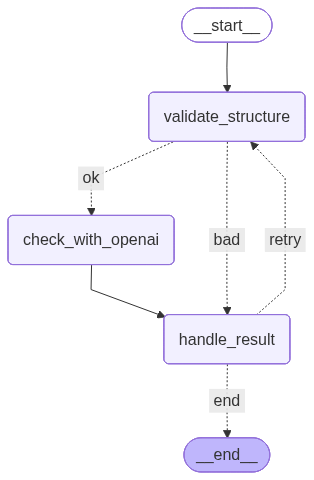

In [11]:
png = app.get_graph().draw_mermaid_png()
display(Image(png))

# Ejemplo de fallos

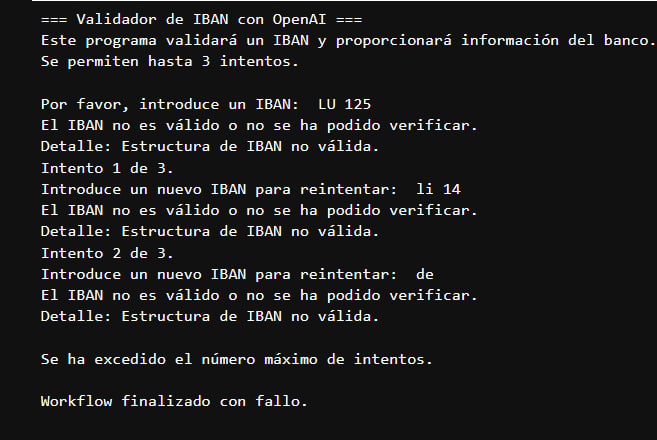

In [13]:
display(Image("ejemplo_fallos.jpg"))

# Otro ejemplo de caso anterior correcto, cuenta extranjera

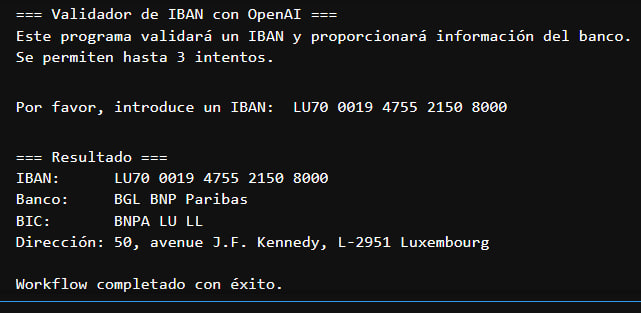

In [15]:
display(Image("ejemplo_iban_ok_extranjero.jpg"))